In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import random
import collections

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
torch.multiprocessing.set_sharing_strategy('file_system')
import torchvision
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import cv2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

Current cuda device  0


In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

#os.chdir('/content/gdrive/MyDrive/sw_ai')

In [4]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

fix_all_seeds(37)
# 경로
WIDTH = 1024
HEIGHT = 1024

# True 인 경우 다른 조건을 주기 위함
TEST = False
NORMALIZE = False
USE_SCHEDULER = False

# 데이터 전처리
resnet_mean = (0.485, 0.456, 0.406)
resnet_std = (0.229, 0.224, 0.225)

# model parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
n_epochs = 17
batch_size = 16
momentum = 0.9
lr = 0.0001
weight_decay = 0.0005

# mask rcnn 에서는 0.5를 기준으로 mask가 있는지 없는지 판단


# 이미지 당 detection 최대 갯수
# 세포 이미지의 경우 500대 단위를 많이 사용하는 편으로, 이미지에 따라 수정
box_detections_per_img = 500

# 겹치는 부분 score 기준
# 0 또는 0.5부터 가장 좋은 결과를 가질 때까지 수정
min_score = 0.5

In [5]:
mask_threshold = 0.35

In [6]:
#데이터 전처리 함
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [7]:
# 이미지 플립
class VerticalFlip:
    def __init__(self, prob):
        self.prob = 1

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target['boxes']
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target['boxes'] = bbox
            target['masks'] = target['masks'].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = 1

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target['boxes']
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target['boxes'] = bbox
            target['masks'] = target['masks'].flip(-1)
        return image, target

In [8]:
class ContrastAdjustment:
    def __init__(self, contrast_factor):
        self.contrast_factor = contrast_factor

    def __call__(self, image, target):
        contrast_factor = 1.0 + random.uniform(0.8, self.contrast_factor)
        image = F.adjust_contrast(image, contrast_factor)
        return image, target

class BrightnessAdjustment:
    def __init__(self, brightness_factor):
        self.brightness_factor = brightness_factor

    def __call__(self, image, target):
        brightness_factor = 1.0 + random.uniform(0.4, self.brightness_factor)
        image = F.adjust_brightness(image, brightness_factor)
        return image, target

class RandomCrop:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, image, target):
        height, width = image.shape[-2:]
        new_height, new_width = self.output_size

        top = random.randint(0, height - new_height)
        left = random.randint(0, width - new_width)

        image = image[:, top:top+new_height, left:left+new_width]
        bbox = target['boxes']
        bbox[:, [0, 2]] -= left
        bbox[:, [1, 3]] -= top
        target['boxes'] = bbox

        return image, target

In [9]:
# 데이터 처리
class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, resnet_mean, resnet_std)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    # Data augmentation for train
    if train:
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

def get_transform1(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    # Data augmentation for train
    if train:
        transforms.append(ContrastAdjustment(1.0))
        transforms.append(RandomCrop((112, 112)))
    return Compose(transforms)


def get_transform2(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    # Data augmentation for train
    if train:
        transforms.append(BrightnessAdjustment(0.5))
        transforms.append(RandomCrop((112, 112)))
    return Compose(transforms)

In [10]:
# 마스크 표기하는 함수
# shape: (height, width)
# return 0:background, 1:mask

def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [11]:
class CellDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None, resize=False,tf=None, chk=0):
        self.transforms = transforms
        self.tf = tf
        self.image_dir = image_dir
        self.df = df
        self.should_resize = True
        self.chk=chk
        
        if self.should_resize:
            self.height = int(1120)
            self.width = int(1120)
        else:
            self.height = 1120
            self.width = 1120
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby('img_id')['mask_rle'].agg(lambda x: list(x)).reset_index()
        for index, row in temp_df.iterrows():
            self.image_info[index] = {'image_id': row['img_id'],
                                      'image_path': os.path.join(self.image_dir, row['img_id']+'.png'),
                                      'annotations': row['mask_rle']}

    def get_box(self, a_mask):
        # 주어진 mask로부터 bbox 확보
        pos = np.where(a_mask)
        #print(len(pos))
        #print(pos)
        if len(pos[0]) == 0 or len(pos[1]) == 0:
            # 객체가 없는 경우
            return [1,3,2,4]
        else:
            # 객체가 있는 경우
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            return [xmin, ymin, xmax+1, ymax+1]

    def __getitem__(self, idx):
        img_path = self.image_info[idx]['image_path']
        img = Image.open(img_path).convert('RGB')

        #if self.should_resize:
            #img = img.resize((self.width, self.height), resample=Image.BILINEAR)
        img =np.array(img)
        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), 224, 224), dtype=np.uint8)

        # bbox 좌표 얻기
        boxes = []
        for i, annotation in enumerate(info['annotations']):
            #print(i)
            mask = rle_decode(annotation, (1024, 1024))
            augmented = self.tf(image=img, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            #print(img.size)
            #print(mask.size)
            #print(self.chk)
            if(self.chk==0):
              image = image
              mask = mask
            elif (self.chk==1):
              image = image[:224,:224, :]
              mask = mask[:224, :224]
            elif (self.chk==2):
              image = image[:224,224:448,:]
              mask = mask[:224, 224:448]
            elif (self.chk==3):
              image = image[:224,448:672,:]
              mask = mask[:224, 448:672]
            elif (self.chk==4):
              image = image[:224,672:896,:]
              mask = mask[:224, 672:896]
            elif (self.chk==5):
              image = image[:224,896:,:]
              mask = mask[:224, 896:]
            elif (self.chk==6):
              image = image[224:448,:224,:]
              mask = mask[224:448, :224]
            elif (self.chk==7):
              image = image[224:448,224:448,:]
              mask = mask[224:448, 224:448]
            elif (self.chk==8):
              image = image[224:448,448:672,:]
              mask = mask[224:448, 448:672]
            elif (self.chk==9):
              image = image[224:448,672:896,:]
              mask = mask[224:448, 672:896]
            elif (self.chk==10):
              image = image[224:448,896:,:]
              mask = mask[224:448, 896:]
            elif (self.chk==11):
              image = image[448:672,:224,:]
              mask = mask[448:672, :224]
            elif (self.chk==12):
              image = image[448:672,224:448,:]
              mask = mask[448:672, 224:448]
            elif (self.chk==13):
              image = image[448:672,448:672,:]
              mask = mask[448:672, 448:672]
            elif (self.chk==14):
              image = image[448:672,672:896,:]
              mask = mask[448:672, 672:896]
            elif (self.chk==15):
              image = image[448:672,896:,:]
              mask = mask[448:672, 896:]
            elif (self.chk==16):
              image = image[672:896,:224,:]
              mask = mask[672:896, :224]
            elif (self.chk==17):
              image = image[672:896,224:448,:]
              mask = mask[672:896, 224:448]
            elif (self.chk==18):
              image = image[672:896,448:672,:]
              mask = mask[672:896, 448:672]
            elif (self.chk==19):
              image = image[672:896, 672:896,:]
              mask = mask[672:896, 672:896]
            elif (self.chk==20):
              image = image[672:896,896:,:]
              mask = mask[672:896, 896:]
            elif (self.chk==21):
              image = image[896:,:224,:]
              mask = mask[896:, :224]
            elif (self.chk==22):
              image = image[896:,224:448,:]
              mask = mask[896:, 224:448]
            elif (self.chk==23):
              image = image[896:,448:672,:]
              mask = mask[896:,448:672]
            elif (self.chk==24):
              image = image[896:,672:896,:]
              mask = mask[896:, 672:896]
            else:
              image = image[896:,896:,:]
              mask = mask[896:, 896:]
            #a_mask = Image.fromarray(a_mask)

            #if self.should_resize:
                #a_mask = a_mask.resize((224, 224), resample=Image.BILINEAR)
            a_mask = np.array(mask) > 0
            masks[i, :, :] = a_mask
            #print(a_mask)
            boxes.append(self.get_box(a_mask))
        # dummy lables
        #print(boxes)
        tmp = boxes.copy()
        if (boxes == [[1,3,2,4]]):
            #print(1)
            labels = [0]
        else:
            labels = [1]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
            
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        #print(boxes)
            #print(2)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        target = {'boxes': boxes,
                  'labels': labels,
                  'masks': masks,
                  'image_id': image_id,
                  'area': area,
                  'iscrowd': iscrowd}


        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.image_info)

In [12]:
import albumentations as A
tf = A.Compose(
    [
        A.Resize(1120,1120),
    ]
)

In [13]:
df_train = pd.read_csv('./train.csv')
#ds_train = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=0)
ds_train1 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=1)
ds_train2= CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=2)
ds_train3 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=3)
ds_train4 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=4)
ds_train5 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=5)
ds_train6 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=6)
ds_train7 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=7)
ds_train8 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=8)
ds_train9 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=9)
ds_train10 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=10)
ds_train11 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=11)
ds_train12= CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=12)
ds_train13 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=13)
ds_train14 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=14)
ds_train15 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=15)
ds_train16 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=16)
ds_train17 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=17)
ds_train18 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=18)
ds_train19 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=19)
ds_train20 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=20)
ds_train21 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=21)
ds_train22 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=22)
ds_train23 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=23)
ds_train24 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=24)
ds_train25 = CellDataset('./data/train_img', df_train, resize=False, transforms=get_transform(train=False),tf=tf,chk=25)
train = ds_train1+ds_train2+ds_train3+ds_train4+ds_train5+ds_train6+ds_train7+ds_train8+ds_train9+ds_train10+ds_train11+ds_train12+ds_train13+ds_train14+ds_train15+ds_train16+ds_train17+ds_train18+ds_train3+ds_train19+ds_train20+ds_train21+ds_train22+ds_train23+ds_train24+ds_train25
dl_train = DataLoader(train, batch_size=16, shuffle=True, num_workers=48, collate_fn=lambda x: tuple(zip(*x)))

In [14]:
dl_train = DataLoader(train, batch_size=32, shuffle=True, num_workers=24, collate_fn=lambda x: tuple(zip(*x)))

In [15]:
import matplotlib.pyplot as plt

In [ ]:
ds_train1

In [ ]:
for i in dl_train:
    print(i)
    break

In [ ]:

plt.subplot(5, 5, 1)
plt.imshow(ds_train1[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 2)
plt.imshow(ds_train2[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 3)
plt.imshow(ds_train3[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 4)
plt.imshow(ds_train4[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 5)
plt.imshow(ds_train5[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 6)
plt.imshow(ds_train6[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 7)
plt.imshow(ds_train7[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 8)
plt.imshow(ds_train8[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 9)
plt.imshow(ds_train9[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 10)
plt.imshow(ds_train10[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 11)
plt.imshow(ds_train11[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 12)
plt.imshow(ds_train12[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 13)
plt.imshow(ds_train13[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 14)
plt.imshow(ds_train14[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 15)
plt.imshow(ds_train15[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 16)
plt.imshow(ds_train16[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 17)
plt.imshow(ds_train17[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 18)
plt.imshow(ds_train18[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 19)
plt.imshow(ds_train19[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 20)
plt.imshow(ds_train20[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 21)
plt.imshow(ds_train21[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 22)
plt.imshow(ds_train22[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 23)
plt.imshow(ds_train23[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 24)
plt.imshow(ds_train24[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(5, 5, 25)
plt.imshow(ds_train25[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.show()



In [ ]:
plt.imshow(ds_train1[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train1[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train2[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train2[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train3[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train3[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train4[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train4[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train5[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train5[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train6[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train6[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train7[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train7[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train8[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train8[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train9[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train9[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train10[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train10[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train11[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train11[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train12[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train12[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train13[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train13[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train14[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train14[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train15[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train15[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train16[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train16[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train17[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train17[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train18[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train18[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train19[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train19[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train20[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train20[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train21[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train21[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train22[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train22[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train23[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train23[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train24[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train24[0][1]['masks'][0], alpha=0.4)
plt.show()
plt.imshow(ds_train25[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(ds_train25[0][1]['masks'][0], alpha=0.4)
plt.show()

In [ ]:
len(ds_train+ds_train1)
print(ds_train2[0][0])

In [16]:
def get_model():
    NUM_CLASSES = 2

    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=box_detections_per_img,
                                                                   image_mean=resnet_mean,
                                                                   image_std=resnet_std)
    else:
        print(1)
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=box_detections_per_img)

    # pretrained 모델의 필요한 부분을 가져오고 새로운 학습을 위해서 해서 설정해야 하는 부분 설정해주기
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

    # get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # replace mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)

    return model

In [17]:
import torch.nn as nn
import torchvision.models

In [18]:
model = get_model()
model = nn.DataParallel(model,device_ids = [3,4,5])
model.to(device)
for param in model.parameters():
    param.requires_grad = True

model.train()
# pretrained 모델의 구조에서 roi head에 있는 box predictor와 mask predictor의 output이 바뀐걸 확인할 수 있음

1


DataParallel(
  (module): MaskRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (b

In [19]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
n_batches = len(dl_train)

In [20]:
from tqdm import tqdm

In [21]:
for epoch in range(1):

    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0

    for batch_idx, (images, targets) in tqdm(enumerate(dl_train, 1)):

        # predic
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask

        # if batch_idx % 10 == 0:
        #     print(f'Batch {batch_idx:3d}/{n_batches:3d}  Batch Train Loss {loss.item():7.3f}  Mask Only Loss {loss_mask:7.3f}')

    #if USE_SCHEDULER:
        #lr_scheduler.step()

    train_loss = loss_accum/n_batches
    train_loss_mask = loss_mask_accum/n_batches

    take_time = time.time()-time_start

    # torch.save(model.state_dict(), f'model_{epoch}.bin')
    prefix = f'Epoch {epoch:2d}/{n_epochs:2d}'
    print(f'{prefix} -- Train Loss {train_loss:.3f} -- Train Mask Only Loss {train_loss_mask:.3f} -- Take time {take_time:.0f}sec')

0it [00:17, ?it/s]


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 3.
Original Traceback (most recent call last):
  File "/home/aicom/.local/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/aicom/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aicom/.local/lib/python3.8/site-packages/torchvision/models/detection/generalized_rcnn.py", line 101, in forward
    features = self.backbone(images.tensors)
  File "/home/aicom/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aicom/.local/lib/python3.8/site-packages/torchvision/models/detection/backbone_utils.py", line 58, in forward
    x = self.fpn(x)
  File "/home/aicom/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aicom/.local/lib/python3.8/site-packages/torchvision/ops/feature_pyramid_network.py", line 192, in forward
    inner_lateral = self.get_result_from_inner_blocks(x[idx], idx)
  File "/home/aicom/.local/lib/python3.8/site-packages/torchvision/ops/feature_pyramid_network.py", line 155, in get_result_from_inner_blocks
    out = module(x)
  File "/home/aicom/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aicom/.local/lib/python3.8/site-packages/torch/nn/modules/container.py", line 217, in forward
    input = module(input)
  File "/home/aicom/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aicom/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py", line 463, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/home/aicom/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py", line 459, in _conv_forward
    return F.conv2d(input, weight, bias, self.stride,
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB (GPU 3; 9.78 GiB total capacity; 8.25 GiB already allocated; 21.44 MiB free; 8.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [ ]:
import torch

# 학습된 모델을 model 변수에 할당한 후 저장
torch.save(model, './model(rcnn-adam).pth')

In [18]:
import torch
model = torch.load("./model(epoch12).pt", map_location=device)

In [27]:
model = get_model()
model.to(device)
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
n_batches = len(dl_train)

checkpoint = torch.load("./model(epoch12).pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

1


In [ ]:
ds_train1[3][1]['masks'].size()

In [ ]:
def analyze_train_sample(model, ds_train, sample_index=10):

    # sample image
    img, targets = ds_train[sample_index]
    print(ds)
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.title('Sample Image')
    plt.show()

    # ground truth
    masks = np.zeros((112, 112))
    for mask in targets['masks']:
        masks = np.logical_or(masks, mask)

    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.imshow(masks, alpha=0.3)
    plt.title('Ground Truth')
    plt.show()

    # pred
    model.eval()
    with torch.no_grad():
        preds = model([img.to(device)])[0]

    plt.imshow(img.cpu().numpy().transpose((1, 2, 0)))
    all_preds_masks = np.zeros((112, 112))
    idx=0
    for mask in preds['masks'].cpu().detach().numpy():
      if(preds['scores'][idx] >0.5):
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > 0.2)
      idx+=1
    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title('Predictions')
    plt.show

    return preds

sample_vi = analyze_train_sample(model, ds_train1, 3)

{'boxes': tensor([[  0.3059,  13.1964, 123.9876, 207.9869],
        [ 15.1502,  16.2942,  98.0202,  65.1958],
        [ 65.1606,   5.3079, 217.1596, 216.7767],
        [  0.0000, 155.2370,  23.8245, 205.6522],
        [  0.3453, 153.5878, 111.1111, 218.0392],
        [  1.4134,  30.0702,  34.0112, 206.3197],
        [  7.7051,   0.6766, 190.6964,  61.2851],
        [ 68.1004,  20.4375, 131.8161, 196.2390],
        [ 74.3458,   1.8168, 194.8323,  46.7324],
        [  0.0000,  67.0868, 195.4394, 213.1793]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8313, 0.5571, 0.2617, 0.2310, 0.2083, 0.2083, 0.1568, 0.0581, 0.0551,
        0.0548], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],



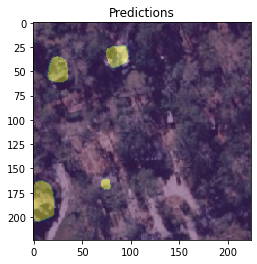

In [47]:
# train 시각화 함수
def analyze_train_sample(model, ds_train, sample_index=20):

    # sample image
    #img1, _ = ds_test1[sample_index]
    img, targets = ds_train[sample_index]
    #print(img1)

    # pred
    model.eval()
    with torch.no_grad():
        #print(img)
        preds = model([img.to(device)])[0]
    plt.imshow(img.cpu().numpy().transpose((1, 2, 0)))
    all_preds_masks = np.zeros((224, 224))
    idx=0
    print(preds)
    for mask in preds['masks'].cpu().detach().numpy():
      if(preds['scores'][idx] >0.4):
        all_preds_masks = np.logical_or(all_preds_masks, mask[0]>0.5)
      idx+=1
    if(rle_encode(all_preds_masks)==''):
      print(1)
    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title('Predictions')
    plt.show

    return preds

sample_vi = analyze_train_sample(model, ds_test, 8)

In [19]:
class CellTestDataset(Dataset):
    def __init__(self, image_dir, transforms=True):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir)]

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        image = Image.open(image_path).convert('RGB')

        if self.transforms:
            image, _ = self.transforms(image=image, target=None)
        return image, image_id

    def __len__(self):
        return len(self.image_ids)

In [20]:
import cv2

In [22]:
#ds_test1 = CellTestDataset('./test_img', transforms=False)
ds_test = CellTestDataset('./data/test_img', transforms=get_transform(train=False))
data_loader = DataLoader(ds_test, batch_size=32, shuffle=False, num_workers=8)
len(ds_test)

60640

In [ ]:
for i in data_loader:
  print(i)
  break

In [23]:
# get mask
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2

    for b in dots:
        if (b > prev+1):
            run_lengths.extend((b+1, 0))
            run_lengths[-1] += 1
            prev = b

    return ' '.join(map(str, run_lengths))

# 겹치는 부분 지우기
def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_or(mask, other_mask)] = 0

    return mask

In [24]:
from tqdm import tqdm

In [25]:
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
model.eval()
submission = []

for sample in tqdm(ds_test):
    if(len(submission) <= 10000):
      continue

    img = sample['image']
    image_id = sample['image_id']
    with torch.no_grad():
        result = model([img.to(device)])[0]

    previous_masks = []
    for i, mask in enumerate(result['masks']):
        score = result['scores'][i].cpu().item()
        #if score < min_score:
            #continue

        # 가장 연관성 높은 mask만 남기기
        mask = mask.cpu().numpy()
        if(score <= 0.475):
          continue
        #print(mask[0])
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > 0.4)
        #print(mask)
        #binary_mask = mask > 0.2
        #binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        previous_masks.append(binary_mask)
        #print(binary_mask)
        rle = rle_encode(binary_mask)
        #print(rle)
    submission.append((image_id, rle))

    # 이미지에 대해서 rle가 생성되지 않으면 빈 prediction 추가
    all_images_ids = [image_id for image_id, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ''))

    if (len(submission)==20000):
      break

In [48]:
model.eval()
submission = []
for sample in tqdm(data_loader):
  #print(len(sample[0]))
  #print(len(sample[1]))
  for i in range(32):
      img = sample[0][i]
      image_id = sample[1][i]
      with torch.no_grad():
          result = model([img.to(device)])[0]

      all_preds_masks = np.zeros((224, 224))
      chk=-1
      if (len(result['scores'])==0):
        rle=-1
        submission.append((image_id, rle))
        continue
      if (max(result['scores'])< 0.4):
        chk = max(result['scores'])
      for i, mask in enumerate(result['masks']):
          #print(mask)
          score = result['scores'][i].cpu().item()

          # 가장 연관성 높은 mask만 남기기
          mask = mask.cpu().numpy()
          #print(mask[0])
          if(score <= 0.4):
            if (chk != score):
              continue
          all_preds_masks = np.logical_or(all_preds_masks, mask > 0.5)
          #print(binary_mask)
          rle = rle_encode(all_preds_masks)
      #print(rle)
      submission.append((image_id, rle))




100%|██████████| 1895/1895 [54:53<00:00,  1.74s/it]


In [49]:
df_sub = pd.DataFrame(submission, columns=['img_id', 'mask_rle'])
df_sub=df_sub.sort_values('img_id')
df_sub.loc[df_sub['mask_rle']=='','mask_rle'] = '-1'
print(df_sub[df_sub["mask_rle"]=='-1'].count())
submission
df_sub

img_id      1099
mask_rle    1099
dtype: int64


,img_id,mask_rle
8639,TEST_00000,20226 9 20450 10 20673 13 20704 7 20897 16 209...
25788,TEST_00001,36063 1 36282 7 36505 8 36728 9 36950 11 37173...
32108,TEST_00002,-1
18784,TEST_00003,245 25 467 29 690 31 914 31 1138 31 1362 32 15...
40545,TEST_00004,17118 18 17148 5 17340 41 17563 44 17787 44 18...
...,...,...
46837,TEST_60635,28339 15 28562 18 28785 20 29007 23 29171 1 29...
14907,TEST_60636,29082 3 29302 17 29524 21 29747 25 29971 28 30...
57059,TEST_60637,285 13 315 13 507 16 537 18 730 18 760 20 954 ...
16238,TEST_60638,14714 2 14922 22 15145 24 15369 25 15592 26 15...


In [50]:
df_sub.to_csv('./sub(rcnn-adv-12epoch).csv', index=False)
df_sub.head()

,img_id,mask_rle
8639,TEST_00000,20226 9 20450 10 20673 13 20704 7 20897 16 209...
25788,TEST_00001,36063 1 36282 7 36505 8 36728 9 36950 11 37173...
32108,TEST_00002,-1
18784,TEST_00003,245 25 467 29 690 31 914 31 1138 31 1362 32 15...
40545,TEST_00004,17118 18 17148 5 17340 41 17563 44 17787 44 18...


In [ ]:
df = pd.read_csv('./submit(31).csv')
df[df['mask_rle']=='-1'].count()
df

In [ ]:
df_sub = pd.DataFrame(submission, columns=['image_id', 'mask_rle'])
df_sub.to_csv('./sub1.csv', index=False)
df_sub.head()